<h1><center>Исследование данных авиакомпании</center></h1>

---

## Сбор данных

In [1]:
import requests
import re
from bs4 import BeautifulSoup
import pandas as pd
import json

In [2]:
URL = 'https://code.s3.yandex.net/learning-materials/data-analyst/festival_news/index.html'
req = requests.get(URL) # сохраняем объект Response в переменную req

In [3]:
# создаем объект BeautifulSoup
soup=BeautifulSoup(req.text, 'lxml')

In [4]:
# Заберем нужную таблицу целиком
table = soup.find('table')

In [5]:
# Список, в котором будут храниться названия столбцов
heading_table = [] 

# Найдем все элементы th внутри table 
for row in table.find_all('th'):  
        heading_table.append(row.text) 

In [6]:
# Список, в котором будут храниться данные из таблицы
content=[] 

# Найдем все элементы tr внутри table 
for row in table.find_all('tr'): 
    # Эта проверка необходима, чтобы пропустить первую строку таблицы с заголовками
    if not row.find_all('th'):
        # В каждой строке контент ячейки обрамляется тегами <td> </td>
        # Необходимо пробежаться в цикле по всем элементам td, вычленить контент из ячеек и добавить его в список 
        # Затем добавить каждый из списков в список content 
        content.append([element.text for element in row.find_all('td')])

In [7]:
# Соберем DataFrame
# в качестве данных передаем двумерный список content, а в качестве заголовков - heading_table
festivals = pd.DataFrame(content, columns=heading_table) 

# Сделаем замену типа данных для даты 
#festivals['Дата проведения']= pd.to_datetime(festivals['Дата проведения'], format='%d.%m.%Y')

festivals

,Название фестиваля,Место проведения,Дата проведения
0,Музыкальный фестиваль «Усадьба Jazz»,Екатеринбург,01.07.2018
1,Фестиваль музыки и технологий Alfa Future People,Нижний Новгород,10.08.2018
2,"Фестиваль еды «О, да! Еда!»",Санкт-Петербург,21.07.2018
3,Доброфест,Ярославль,29.07.2018
4,Park Live,Москва,28.07.2018
5,Пикник Афиши,Москва,04.08.2018
6,VK FEST,Санкт-Петербург,29.07.2018
7,"Фестиваль «О, да! Еда!»",Иркутск,25.08.2018
8,"Фестиваль «О, да! Еда!»",Владивосток,02.09.2018
9,Видфест,Москва,08.09.2018


## Исследовательский анализ данных, SQL
Данное задание выполнялось на учебной платформе, поэтому сами SQL-запросы не надо было «заворачивать» в функцию и каким-то образом пересылать в БД.

### Задача 1
Изучите таблицу `airports` и выведите список городов (`city`), в которых есть аэропорты.

***
```SQL
SELECT
    DISTINCT(city) 
FROM
    airports
```
***

### Задача 3
Изучите таблицу `flights` и подсчитайте количество вылетов (`flight_id`) из каждого аэропорта вылета (`departure_airport`). Назовите переменную `cnt_flights` и выведите её вместе со столбцом `departure_airport`. Результат отсортируйте в порядке убывания количества вылетов.

***
```SQL
SELECT
    departure_airport,
    COUNT(flight_id) AS cnt_flights
FROM
    flights
GROUP BY
    departure_airport
ORDER BY
    cnt_flights DESC
```
***

### Задача 3
Найдите количество рейсов на каждой модели самолёта с вылетом в сентябре 2018 года. Назовите получившееся поле `flights_amount` и выведите его, также выведите поле `model`. Столбцы в таблице должны быть выведены в следующем порядке: `model`, `flights_amount`

***
```SQL
SELECT 
   DISTINCT aircrafts.model AS model,
   COUNT(DISTINCT flights.flight_id) as flights_amount
FROM
    aircrafts
LEFT JOIN flights ON flights.aircraft_code = aircrafts.aircraft_code
WHERE
    EXTRACT(MONTH FROM departure_time) = 9
GROUP BY
    model
```
***

### Задача 4
Посчитайте количество рейсов по всем моделям самолетов `Boeing` и `Airbus` в `сентябре`. Назовите получившуюся переменную `flights_amount` и выведите ее.

***
```SQL
SELECT 
	COUNT(flights.flight_id) as flights_amount,
	CASE WHEN model LIKE 'Airbus%' THEN 'Airbus' 
	WHEN model LIKE 'Boeing%' THEN 'Boeing' 
    ELSE 'other' END AS type_aircraft
FROM
    aircrafts
LEFT JOIN flights ON flights.aircraft_code = aircrafts.aircraft_code
WHERE
    EXTRACT(MONTH FROM departure_time) = 9 AND
    (aircrafts.model LIKE 'Airbus%' OR aircrafts.model LIKE 'Boeing%')
GROUP BY
   type_aircraft
```
***

### Задача 5
Посчитайте среднее количество прибывающих рейсов в день для каждого города за `август 2018 года`. Назовите получившееся поле `average_flights`, вместе с ней выведите столбец `city`. Столбцы в таблице должны быть выведены в следующем порядке: `city`, `average_flights`

***
```SQL
SELECT
    airports.city AS city,
    -- так как самолеты летают не каждый день, то надо посчитать количество уникальных дней когда есть полеты
    COUNT(flights.flight_id) / COUNT(DISTINCT EXTRACT(DAY FROM flights.arrival_time))::real AS average_flights
FROM
    airports
INNER JOIN flights ON flights.arrival_airport = airports.airport_code
WHERE
    EXTRACT(MONTH FROM flights.arrival_time) = 8
GROUP BY
    city
```
***

### Задача 6
Установите фестивали, которые проходили с `23 июля` по `30 сентября 2018` года в `Москве`, и `номер недели`, в которую они проходили. Выведите название фестиваля `festival_name` и номер недели `festival_week`.

***
```SQL
SELECT
    festival_name AS festival_name,
    EXTRACT(WEEK FROM festival_date) AS festival_week
FROM 
    festivals
WHERE 
    festival_city LIKE 'Москва' AND
    festival_date::date BETWEEN '018-07-23' AND '2018-09-30'
```
***

### Задача 7
Для каждой недели с `23 июля` по `30 сентября 2018` года посчитайте количество билетов, купленных на рейсы в `Москву `(номер недели `week_number` и количество билетов `ticket_amount`). Получите таблицу, в которой будет информация о количестве купленных за неделю билетов; отметка, проходил ли в эту неделю фестиваль; название фестиваля `festival_name` и номер недели `week_number`.
Столбцы в таблице должны быть выведены в следующем порядке: `week_number`, `ticket_amount`, `festival_week`,  `festival_name`

***
```SQL
SELECT
    EXTRACT(WEEK FROM flights.arrival_time) AS week_number,
    COUNT(ticket_flights.ticket_no) AS ticket_amount,
    festivals.festival_week,
    festivals.festival_name
    
FROM
    flights
LEFT JOIN airports ON airports.airport_code = flights.arrival_airport
LEFT JOIN ticket_flights ON ticket_flights.flight_id = flights.flight_id
LEFT JOIN 
    (SELECT
         festival_name,
         EXTRACT(WEEK FROM festival_date) AS festival_week
     FROM
         festivals
     WHERE
         (festival_date BETWEEN '2018-07-23' AND '2018-09-30') AND
         festival_city = 'Москва' 
    ) AS festivals
    ON festivals.festival_week = EXTRACT(WEEK FROM arrival_time)
    
WHERE
    flights.arrival_time BETWEEN '2018-07-23' AND '2018-10-01' AND
    airports.city = 'Москва'
    
GROUP BY
    week_number,
    festival_week,
    festival_name
```
***

## Исследовательский анализ данных, Python
У вас есть файлы, в которых содержатся результаты запросов из предыдущих заданий.
- `query_1.csv` — результат первого запроса. В нём содержится информация о:
- - model — модели самолета
- - flights_amount — количество рейсов для каждой модели самолетов model в сентябре 2018 года
- `query_3.csv` — результат третьего запроса. В нём содержится информация о:
- - city — городах
- - average_flights — среднем количестве рейсов, прибывающих в город city за день в сентябре 2018 года

### Загрузка данных

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

In [24]:
model = pd.read_csv('datasets/chapter_06_project_F9_query_1.csv')
city = pd.read_csv('datasets/chapter_06_project_F9_query_3.csv')

### Проверка данных

In [10]:
model.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 2 columns):
model             8 non-null object
flights_amount    8 non-null int64
dtypes: int64(1), object(1)
memory usage: 256.0+ bytes


In [11]:
city.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101 entries, 0 to 100
Data columns (total 2 columns):
city               101 non-null object
average_flights    101 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.7+ KB


In [12]:
model.head()

,model,flights_amount
0,Airbus A319-100,607
1,Airbus A321-200,960
2,Boeing 737-300,630
3,Boeing 767-300,600
4,Boeing 777-300,300


In [13]:
city.head()

,city,average_flights
0,Абакан,3.870968
1,Анадырь,1.000000
2,Анапа,2.161290
3,Архангельск,5.354839
4,Астрахань,2.451613


Первичный осмотр данных каких-то аномалий не выявил. Но, чтобы избежать возможного дублирования в значениях переведу все текстовые данные в нижний регистр. 

In [14]:
def my_lower(data, *columns):
    '''
    Функция принимает DataFrame и названия столбцов в которых нужно произвести замену.
    В случае ошибки должно быть предупреждение, что что-то сломалось 
    '''
    
    for column in columns:
        try:
            data[column] = data[column].str.lower()  
        except:
            print('Что-то пошло не так')

In [15]:
my_lower(model, 'model')
my_lower(city, 'city')

### Топ-10 городов по количеству рейсов

In [16]:
city_top10 = city.sort_values(by='average_flights', ascending=False).head(10).copy()
city_top10

,city,average_flights
43,москва,129.774194
70,санкт-петербург,31.161290
54,новосибирск,17.322581
33,красноярск,11.580645
20,екатеринбург,11.322581
67,ростов-на-дону,10.193548
63,пермь,10.129032
10,брянск,10.000000
74,сочи,9.612903
84,ульяновск,9.580645


In [17]:
def my_hist(date, column1, column2, label, name):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(111)

    # график
    x = date[column1]
    y = date[column2]
    ax.bar(x, y, alpha=1, label=label)

    # глучшения  
    ax.set_title(name, size=20)
    ax.set_ylabel(label, size=15)
    ax.legend(fontsize=15)
    ax.grid(True)
    for label in ax.get_xticklabels():
        label.set_rotation(90)

    plt.show();

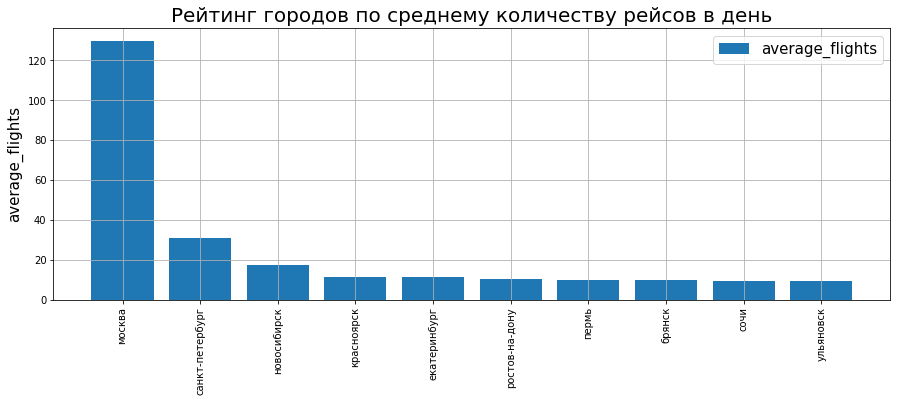

In [18]:
my_hist(city_top10, 'city', 'average_flights', 'average_flights', 
        'Рейтинг городов по среднему количеству рейсов в день')

Первичный осмотр данных каких-то аномалий не выявил. Но, чтобы избежать возможного дублирования в значениях переведу все текстовые данные в нижний регистр. 

Предоставленные данные не позволяют посчитать точное количество рейсов за месяц, так как выгрузка содержит только среднее в день. В предыдущих задачах (работа с SQL) было выявлено, что не во все города самолеты летают каждый день. Поэтому считаю не корректным умножать известное нам среднее (дано в выгрузке) на количество дней в месяце. Буду исходить из предположения, что если среднее количество ресов в день больше, то и за месяц рейсов будет больше. 

Получившийся график однозначно показывает города лидеры: Москва, СПб, Новосибирск. 

### Модели самолетов и количество рейсов

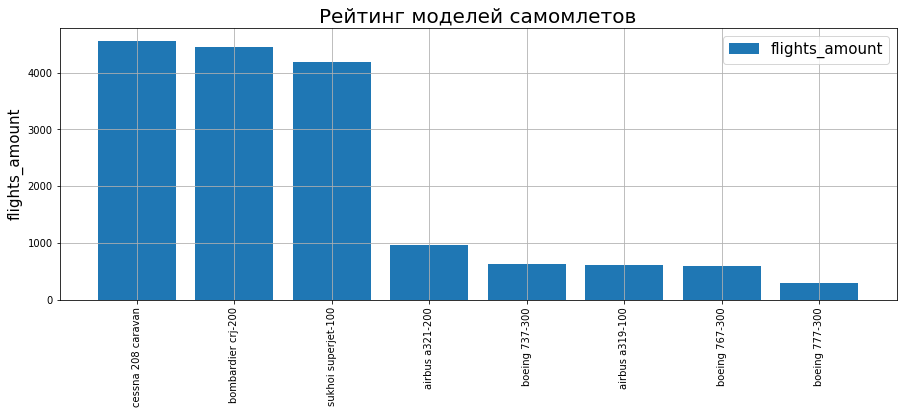

In [19]:
model = model.sort_values(by='flights_amount', ascending=False)
my_hist(model, 'model', 'flights_amount', 'flights_amount', 'Рейтинг моделей самомлетов')

Для меня это настоящее открытие, но ТОП3 модели самолетов: Cessna, Bombardier, Sukhoi. Больше всего удивляют первые две позиции. Cessna - самолет для 9 пассажиров. Bombardier - самолет для 24 пассажиров. Получается, что большая часть перелетов это малая (прям вот совсем малая) авиация + бизнес-полеты. Интересно посмотреть на долю каждой модели от общего числа полетов

In [20]:
total = model['flights_amount'].sum()
model['share'] = round(model['flights_amount'] / total * 100)
model

,model,flights_amount,share
6,cessna 208 caravan,4557,28.0
5,bombardier crj-200,4446,27.0
7,sukhoi superjet-100,4185,26.0
1,airbus a321-200,960,6.0
2,boeing 737-300,630,4.0
0,airbus a319-100,607,4.0
3,boeing 767-300,600,4.0
4,boeing 777-300,300,2.0


55% всех полетов сентября 2018 пришлось на две модели самолетов:  Cessna и Bombardier. Удивительно ) 

### Города и количество рейсов

In [21]:
city = city.sort_values(by='average_flights', ascending=False)

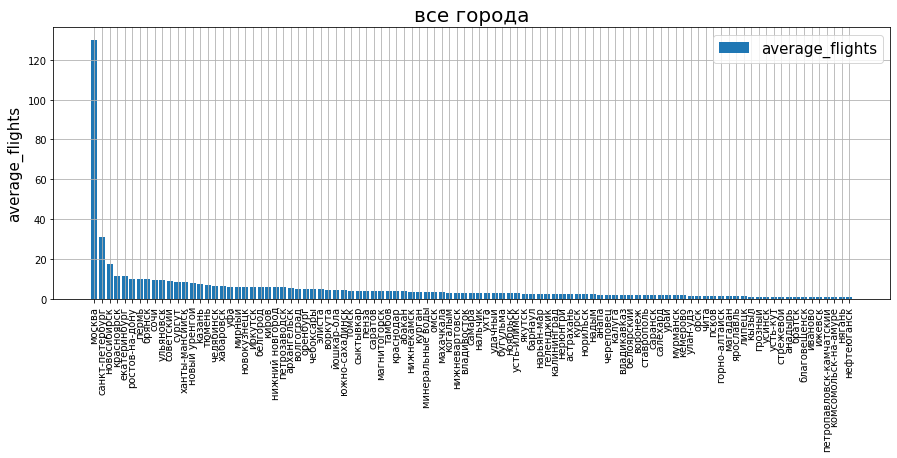

In [22]:
my_hist(city, 'city', 'average_flights', 'average_flights', 'все города')

Что касается гигантского количества рейсов в Москве (если сравнивать с остальными городами), то объяснение здесь достаточно простое. Москва является единственным (к сожалению) крупнейшим хабом в России. Поэтому почти все перелеты идут через данный город. 
